In [9]:
import math
import os
import numpy as np
from shapely.geometry import Point
import geopandas as gpd

In [ ]:
WGS84_PROJECTION = 'epsg:4326'
BRITISH_NATIONAL_GRID_PROJECTION = 'epsg:27700'

In [99]:
# Load Great Britain shape file
# (Download zip from http://www.diva-gis.org/gdata, 
# select country=United Kingdom and subject=Administrative areas;
# extract GBR_adm0.shp and GBR_adm0.shx from zip file.  
# These are in WGS84 lat/lon coordinate reference system)

shapefile = os.path.expanduser('~/data/geospatial/GBR_adm0.shp')
country = gpd.read_file(shapefile)
country.crs = {'init': WGS84_PROJECTION}

In [101]:
# Reproject to BNG, which is in meters from the south west corner.
country = country.to_crs(BRITISH_NATIONAL_GRID_PROJECTION)

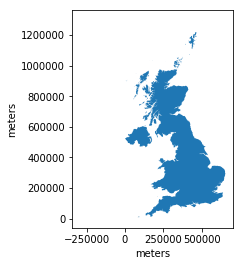

In [102]:
ax = country.plot()
ax.set_ylabel('meters')
ax.set_xlabel('meters');

In [103]:
country.bounds

,minx,miny,maxx,maxy
0,-296677.820916,5408.466518,655695.560156,1.295640e+06


In [51]:
# Create a regular grid
# First, find the required grid spacing in meters.

def grid_spacing(search_radius):
    """Find a regular grid spacing such that, if we draw circles at every grid point with radius == grid_spacing, 
    then the circles will cover the entire area."""
    hypotenuse = search_radius * 2
    grid_spacing = math.sqrt(hypotenuse**2 / 2)
    return grid_spacing

search_radius_km = 25
step_meters = grid_spacing(search_radius=search_radius_km) * 1000

In [54]:
# Create a grid.  Adapted from https://gis.stackexchange.com/a/309102
grid = np.mgrid[0:country.bounds.maxx:step_meters, 0:country.bounds.maxy:step_meters]

# Extract x and y coordinates as flat arrays
grid_x = np.ravel(grid[0])
grid_y = np.ravel(grid[1])

In [116]:
grid_gs = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(x=grid_x, y=grid_y),
    crs=BRITISH_NATIONAL_GRID_PROJECTION)

In [171]:
# Simplify the country geometry, so we can figure out if each grid point is within the country
# in a sensible amount of compute time :)
country_simplified = country.simplify(tolerance=3000, preserve_topology=True)

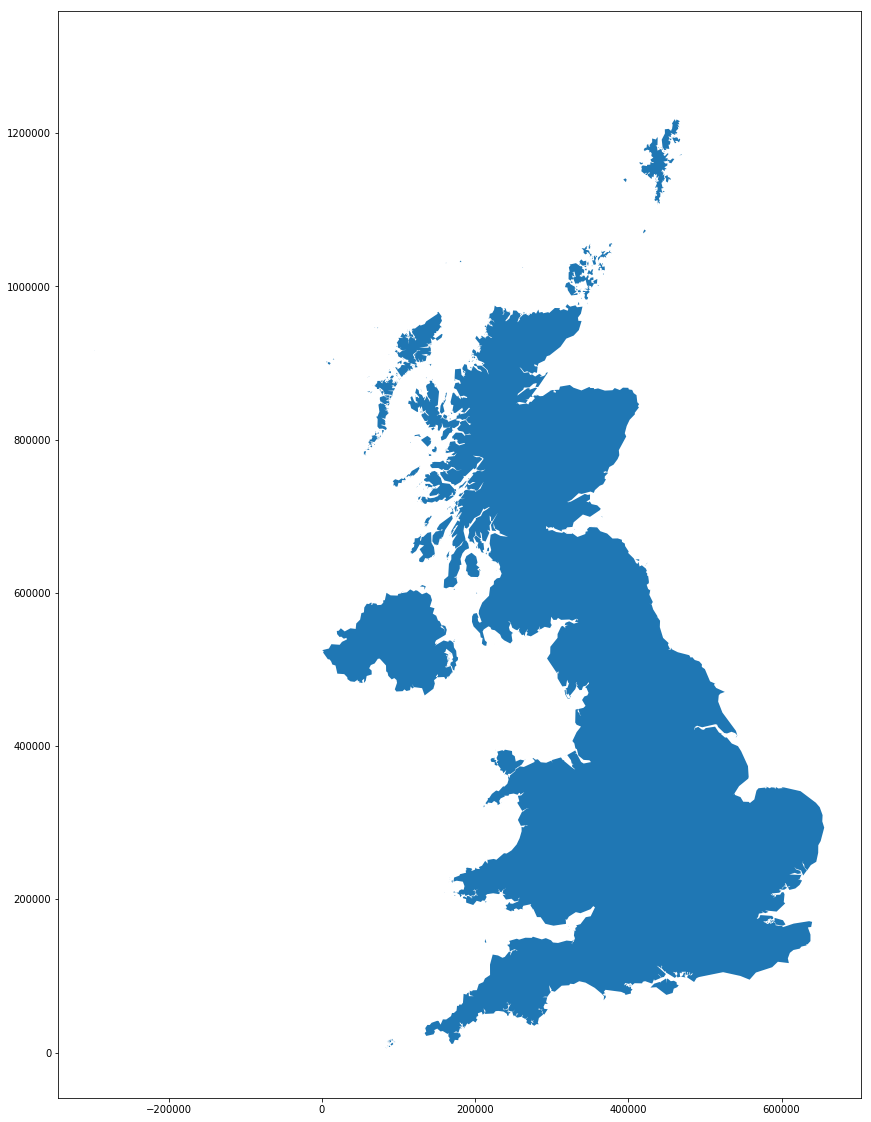

In [172]:
country_simplified.plot(figsize=(20, 20))

In [150]:
country_geom = country_simplified.geometry[0]

In [151]:
# Get a mask for each point in the grid.  The mask is True if the Point is within the country.
mask = grid_gdf.apply(lambda row: row.geometry.within(country_geom), axis='columns')

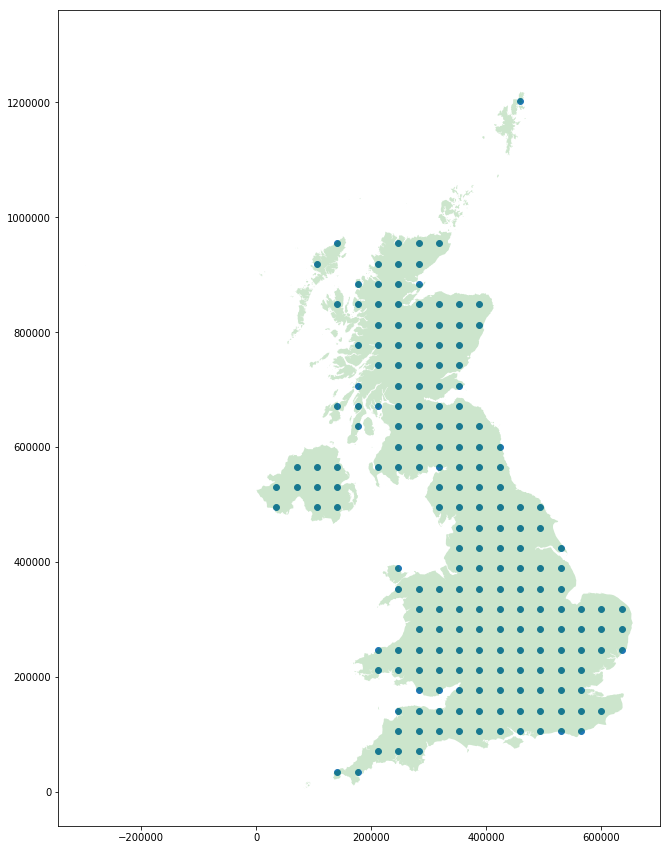

In [197]:
grid_within_country = grid_gdf.loc[mask]
grid_within_country.crs = {'init': BRITISH_NATIONAL_GRID_PROJECTION}
ax = grid_within_country.plot(figsize=(15, 15), markersize=35)
country.plot(ax=ax, color='green', alpha=0.2);

In [198]:
# Convert back to lat/lon for querying PVOutput.org
grid_within_country = grid_within_country.to_crs(WGS84_PROJECTION)

In [200]:
def swap_x_y(gdf):
    return gdf.apply(lambda row: Point(row.geometry.y, row.geometry.x), axis='columns')

# For some reason, x and y coordinates have been swapped!
grid_within_country['geometry'] = swap_x_y(grid_within_country)

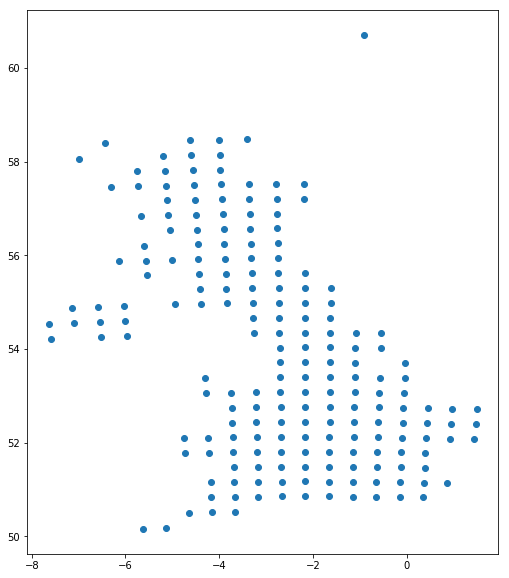

In [225]:
ax = grid_within_country.plot(figsize=(10, 10));

In [206]:
len(grid_within_country)

196

In [222]:
def to_dataframe(gdf):
    lst = [{'lon': point.x, 'lat': point.y} for key, point in gdf.geometry.items()]
    return pd.DataFrame(lst)

to_dataframe(grid_within_country).to_csv(
    '~/dev/python/openclimatefix/solar/pvoutput/uk_grid_points.csv',
    index=False)

In [223]:
!head ~/dev/python/openclimatefix/solar/pvoutput/uk_grid_points.csv

lat,lon
54.220244027621725,-7.596602015979754
54.536457686550555,-7.639920160571421
54.56067223408015,-7.095755330295176
54.877128874601816,-7.13570854565991
54.2656986656687,-6.515790541993777
54.58244267314992,-6.550822253618599
54.89915443971269,-6.5865417824130414
58.064412041261846,-6.9859870279898715
50.1617086962641,-5.621882026352262
